In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from os import XATTR_CREATE
import torch
import torch.nn as  nn
import torch.nn.functional as F
from torch import Tensor

class BasicBlock(nn.Module):
  exp_dim_factor=1

  def __init__(self,in_channels,out_channels,downsample_func=None,stride=1):
    super(BasicBlock,self).__init__()

    self.exp_dim_factor = 1
    self.downsample_func = downsample_func

    #definition of block
    self.conv1=nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,stride=stride,padding=1)
    self.batch1 = nn.BatchNorm2d(out_channels)

    self.conv2=nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=3,stride=1,padding=1)
    self.batch2 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()

  def forward(self,x: Tensor):
    #identity = x.clone()
    out=self.relu(self.batch1(self.conv1(x)))
    out=self.batch2(self.conv2(out))

    if self.downsample_func is not None:
      x = self.downsample_func(x)

    out = out + x
    out = self.relu(out)
    return out


class Bottleneck(nn.Module):
  # expands dim factor
  exp_dim_factor=4

  def __init__(self,in_channels,out_channels,downsample_func=None,stride=1):
    super(Bottleneck,self).__init__()
    self.exp_dim_factor = 4
    self.downsample_func = downsample_func

    #definition of block
    self.conv1=nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=1,stride=1,padding=0)
    self.batch_norm1 = nn.BatchNorm2d(out_channels)

    self.conv2=nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=3,stride=stride,padding=1)
    self.batch_norm2 = nn.BatchNorm2d(out_channels)

    self.conv3=nn.Conv2d(in_channels=out_channels,out_channels=(out_channels*self.exp_dim_factor),kernel_size=1,stride=1,padding=0)
    self.batch_norm3 = nn.BatchNorm2d(out_channels*self.exp_dim_factor)

    self.relu = nn.ReLU()

  def forward(self,x: Tensor):
    #copy the original input == identity to use in the final operation
    identity = x.clone()

    x = self.relu(self.batch_norm1(self.conv1(x)))
    x = self.relu(self.batch_norm2(self.conv2(x)))
    x = self.batch_norm3(self.conv3(x))

    #if downsample of identity is needed
    if self.downsample_func is not None:
      identity = self.downsample_func(identity)

    x += identity
    out = self.relu(x)
    return out


class ResNet(nn.Module):


  def __init__(self,blockType,layer_list,num_classes,num_channels):
    super(ResNet,self).__init__()

    self.in_channels =64
    layers = []

    # input fixed layer
    self.conv1 = nn.Conv2d(in_channels=num_channels,out_channels=64,kernel_size=7,stride=2,padding=3,bias=False)
    self.batch_norm1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

    # make the layers
    layers.append(self.make_layer(blockType,layer_list[0],64))
    layers.append(self.make_layer(blockType,layer_list[1],128,stride=2))
    layers.append(self.make_layer(blockType,layer_list[2],256,stride=2))
    layers.append(self.make_layer(blockType,layer_list[3],512,stride=2))
    #self.layer1=self.make_layer(Bottleneck,layer_list[0],64)
    #self.layer2=self.make_layer(Bottleneck,layer_list[1],128,stride=2)
    #self.layer3=self.make_layer(Bottleneck,layer_list[2],256,stride=2)
    #self.layer4=self.make_layer(Bottleneck,layer_list[3],512,stride=2)

    self.mid_layer = nn.Sequential(*layers)


    # finalize out layers
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512*blockType.exp_dim_factor, num_classes)



  def forward(self, x: Tensor):
    x = self.relu(self.batch_norm1(self.conv1(x)))
    x = self.maxpool(x)

    #x=self.layer1(x)
    #x=self.layer2(x)
    #x=self.layer3(x)
    #x=self.layer4(x)
    x = self.mid_layer(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

  def make_layer(self,blockType,num_block,planes,stride=1):
    layers = []

    downsample_f = None
    # if there is a stride, dimentions of input changes
    # if the input shape not planes*blockType.exp_dim_factor
    if stride>1 or self.in_channels!=planes*blockType.exp_dim_factor :
      downsample_f = nn.Sequential(
          nn.Conv2d(self.in_channels,planes*blockType.exp_dim_factor,kernel_size=1,stride=stride),
          nn.BatchNorm2d(planes*blockType.exp_dim_factor)

      )


    #1st block with stride 2, we will need to do dimention reduction on X
    layers.append(blockType(self.in_channels,planes,downsample_func=downsample_f,stride=stride))

    self.in_channels = planes*blockType.exp_dim_factor
    #NO Stride for the remainign blocks
    for _ in range(1,num_block):
      layers.append(blockType(self.in_channels,planes,downsample_func=None))

    return nn.Sequential(*layers)


def ResNet50(num_classes, channels=3):
  return ResNet(Bottleneck,[3,4,6,3],num_classes=num_classes,num_channels=channels)
def ResNet34(num_classes, channels=3):
  return ResNet(BasicBlock,[3,4,6,3],num_classes=num_classes,num_channels=channels)






In [ ]:
net = ResNet50(10,3)

In [20]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [21]:
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, num_workers=2)

test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(test, batch_size=128,shuffle=False, num_workers=2)

In [23]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

ship


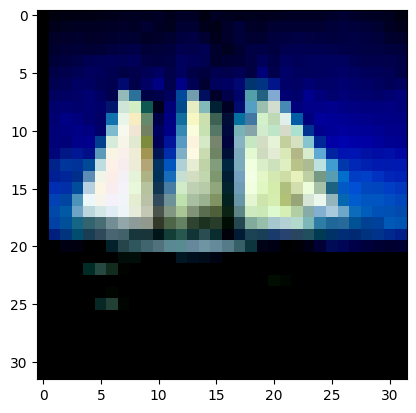

In [39]:
i,l = next(iter(trainloader))
import matplotlib.pyplot as plt
x=15
image = i[x]
image = torch.permute(image,(1,2,0))
print(classes[l[x]])
plt.imshow(image)

In [6]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [46]:
def validate (model,loss_fn,val_ds,device):
  model.eval()
  val_loss=0
  correct=0
  acc_batch=0

  with torch.no_grad():
    for val_imgs, val_lbls in val_ds:
      val_imgs = val_imgs.to(device)
      #print(val_lbls)
      val_lbls = val_lbls.to(device)
      outputs = model(val_imgs)
      loss = loss_fn(outputs,val_lbls)
      val_loss+=loss.item()

      _,pred = torch.max(outputs,1)
      correct = ((pred == val_lbls).sum().item())
      acc_batch += correct/val_lbls.size(0)


  avg_acc =acc_batch/len(val_ds)
  avg_loss = val_loss/len(val_ds)
  return avg_loss,avg_acc


In [42]:
net = ResNet50(10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [47]:
net.to(device)
EPOCHS = 200

epoch_loss =[]
epoch_val_loss = []
epoch_acc = []
for epoch in range(EPOCHS):
    losses = []
    running_loss = 0
    batch_running_losses=0
    for i, inp in enumerate(trainloader):

        inputs, labels = inp
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        #print(next(net.parameters()).is_cuda, inputs.is_cuda, labels.get_device())
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        batch_running_losses += loss.item()

        if i%100 == 0 and i > 0:
            print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)
            running_loss = 0.0

    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)

    epoch_loss.append(batch_running_losses/len(trainloader))
    #validate data for epoch
    loss_epoch,acc_epoch = validate(net,criterion,testloader,device=device)
    epoch_val_loss.append(loss_epoch)
    epoch_acc.append(acc_epoch)

print('Training Done')

Loss [1, 100](epoch, minibatch):  1.7285338485240935
Loss [1, 200](epoch, minibatch):  1.7072782301902771
Loss [1, 300](epoch, minibatch):  1.703387793302536
Loss [2, 100](epoch, minibatch):  1.700216338634491
Loss [2, 200](epoch, minibatch):  1.6974801015853882
Loss [2, 300](epoch, minibatch):  1.6873995625972749
Loss [3, 100](epoch, minibatch):  1.722737295627594
Loss [3, 200](epoch, minibatch):  1.682619993686676
Loss [3, 300](epoch, minibatch):  1.6698528289794923
Loss [4, 100](epoch, minibatch):  1.7035742008686066
Loss [4, 200](epoch, minibatch):  1.6526390385627747
Loss [4, 300](epoch, minibatch):  1.6638397121429442
Loss [5, 100](epoch, minibatch):  1.6654961895942688
Loss [5, 200](epoch, minibatch):  1.664181468486786
Loss [5, 300](epoch, minibatch):  1.637188377380371
Loss [6, 100](epoch, minibatch):  1.6635913038253785
Loss [6, 200](epoch, minibatch):  1.6423424172401428
Loss [6, 300](epoch, minibatch):  1.6189203441143036
Loss [7, 100](epoch, minibatch):  1.6434324038028718

In [3]:
correct=0
total=0

with torch.no_grad():
    for data in testloader:
      imgs,lbls = data
      imgs,lbls = imgs.to(device),lbls.to(device)
      outs = net(imgs)
      _,predicted=torch.max(outs,1)
      total+=lbls.size(0)
      correct+=(predicted==lbls).sum().item()


print('Accuracy on 10,000 test images: ', 100*(correct/total), '%')



NameError: name 'torch' is not defined

In [ ]:
predicted_cpy = predicted.cpu()
predicted_cpy.numpy()


NameError: name 'predicted' is not defined

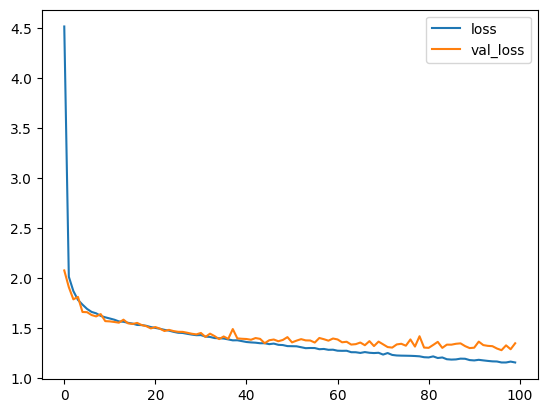

In [12]:
import matplotlib.pyplot as plt
plt.plot(range(EPOCHS),epoch_loss,label='loss')
plt.plot(range(EPOCHS),epoch_val_loss,label='val_loss')
plt.legend()

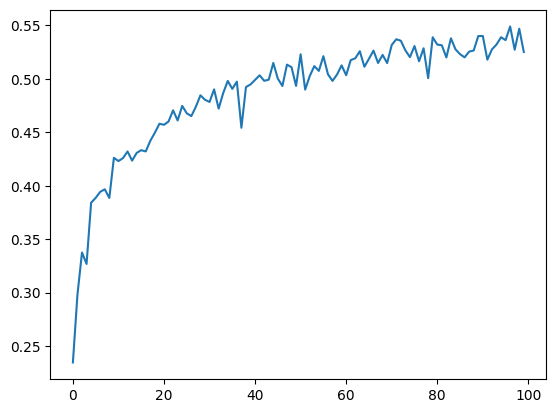

In [13]:
plt.plot(range(EPOCHS),epoch_acc,label='acc')